构建概率图模型大致需要3个步骤：
1. 定义随机变量，即图中的节点；
2. 定义图的结构；
3. 定义每个局部分布的数值参数。

> 在整个这一章中，我们会做一个假设，即数据集是i.i.d的，独立同分布（Independently and Identically Distributed）的缩写。这意味着每个变量都假设服从同样的概率分布，且每个观测又独立于数据集中的其他变量。

In [22]:
# data(iris)
# x <- iris
# colnames(x) <- c("sepal_length","sepal_width","petal_length","petal_width","class")
x=read.csv("http://archive.ics.uci.edu/ml/machine-learning-databases/
iris/iris.data",col.names=c("sepal_length","sepal_width","petal_length","petal_width","class"))
head(x)

sepal_length,sepal_width,petal_length,petal_width,class
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa


In [23]:
library(psych)
describe(x)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
sepal_length,1,149,5.848322,0.8285941,5.8,5.814876,1.03782,4.3,7.9,3.6,0.29702268,-0.6075972,0.06788107
sepal_width,2,149,3.051007,0.4334989,3.0,3.036364,0.29652,2.0,4.4,2.4,0.34308357,0.2243420,0.03551361
petal_length,3,149,3.774497,1.7596512,4.4,3.777686,1.77912,1.0,6.9,5.9,-0.28365705,-1.4006469,0.14415624
petal_width,4,149,1.205369,0.7612920,1.3,1.192562,1.03782,0.1,2.5,2.4,-0.11544665,-1.3463182,0.06236747
class*,5,149,2.006711,0.8178469,2.0,2.008264,1.48260,1.0,3.0,2.0,-0.01218523,-1.5148837,0.06700063


In [24]:
library(plyr)
y = daply(x,.(class),nrow)/nrow(x)
y

Iris-setosa Iris-versicolor  Iris-virginica 
      0.3288591       0.3355705       0.3355705

In [25]:
# P(SepalLength,Class)=P(SepalLength|Class)·P(Class)
daply(x,.(class),function(n) mean(n$sepal_length))

Iris-setosa Iris-versicolor  Iris-virginica 
       5.004082        5.936000        6.588000

In [26]:
daply(x,.(class),function(n) var(n$sepal_length))

Iris-setosa Iris-versicolor  Iris-virginica 
      0.1266497       0.2664327       0.4043429

In [27]:
q <- quantile(x$sepal_width,seq(0,1,0.33))
q

0%   33%   66%   99% 
2.000 2.900 3.200 4.152

In [28]:
x$sepal_width_cat[x$sepal_width < q['33%']] = 'small'
x$sepal_width_cat[(x$sepal_width >= q['33%']) & (x$sepal_width < q['66%'])] = 'medium'
x$sepal_width_cat[x$sepal_width >= q['66%']] = 'large'

In [29]:
#P(dsw|class)
p1 <- daply(x,.(sepal_width_cat,class),function(n) nrow(n))
p1

,Iris-setosa,Iris-versicolor,Iris-virginica
large,36,5,13
medium,12,18,18
small,1,27,19


In [30]:
p1 <- p1/colSums(p1)
p1

,Iris-setosa,Iris-versicolor,Iris-virginica
large,0.7346939,0.1020408,0.2653061
medium,0.2400000,0.3600000,0.3600000
small,0.0200000,0.5400000,0.3800000


---

# 通过推断学习
## 先验概率
- P(θ=0.2)=0.2 有20%的几率更趋向反面（即正面朝上的几率为0.2）
- P(θ=0.5)=0.75 我们相信硬币有75%的几率是公平的（即正面朝上的几率为0.5）
- P(θ=0.8)=0.05 有5%的几率趋向正面（即正面朝上的几率为0.8）

In [32]:
posterior <- function(prob, nh, nt, Theta =c(0.2, 0.5, 0.8)) 
{ 
        x =numeric(3)  
        for (i in 1:3) 
                 x[i] =prob[i] *(Theta[i]^nh) *((1 -Theta[i])^nt)  
        norm =sum(x)  
        return(x/norm)  
} 

In [33]:
posterior(c(0.2,0.75,0.05),2,8)

[1] 6.469319e-01 3.530287e-01 3.948559e-05

🔀我们做了下面的试验：
2次正面朝上和8次反面朝上

硬币以65%的概率趋向于反面朝上。但是硬币的公平度还是35%，依然不小。

> 最后，我们给出一个处理概率计算时的必要技巧。当你需要把许多小数值相乘时，使用对数的加和，而不是原始值和乘法。因此新的算法会用到等式：log(ab)=log(a)+log(b)

In [34]:
posterior <- function(prob, nh, nt, Theta =c(0.2, 0.5, 0.8)) 
{ 
        x =numeric(3)  
        for (i in 1:3) 
                 x[i] =x[i] =exp(log(prob[i]) +nh *log(Theta[i]) +nt *log(1 -Theta[i]))
        norm =sum(x)  
        return(x/norm)  
} 

In [36]:
posterior(c(1/3,1/3,1/3),2,8,c(0.2,0.5,0.8))  

[1] 0.8727806225 0.1270062963 0.0002130812

---

empirical distribution 经验分布

In [2]:
library(graph)
library(Rgraphviz) 
library(plyr)  

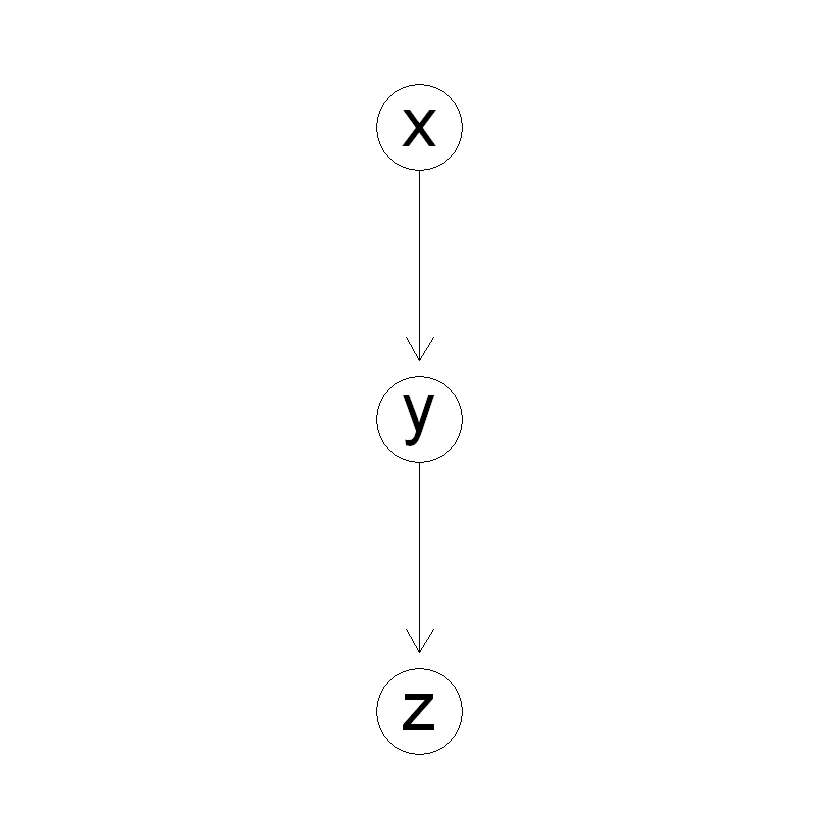

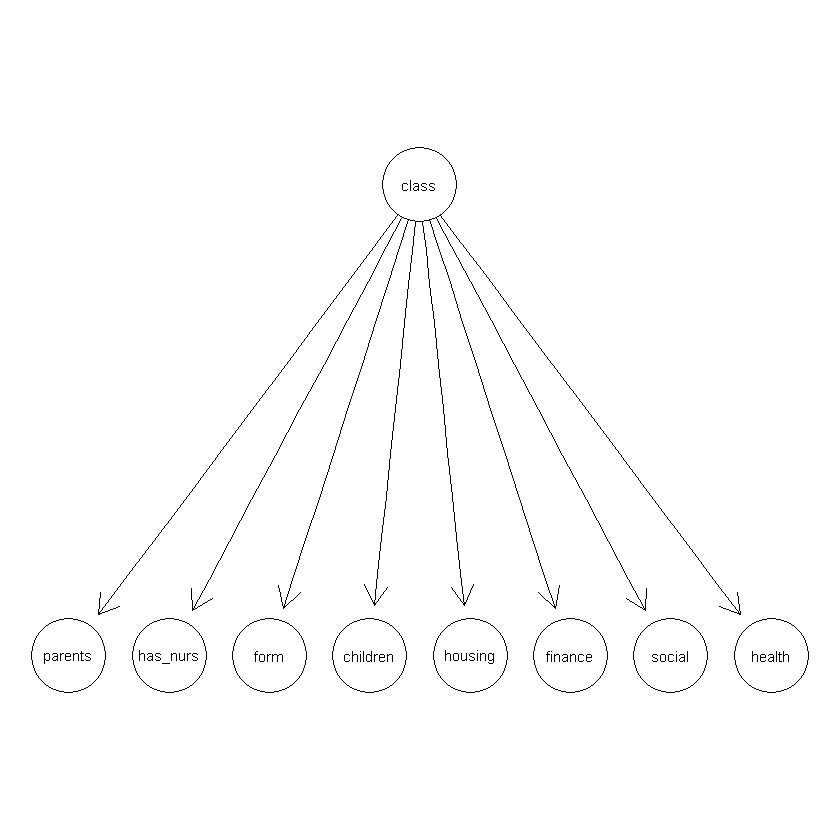

In [3]:
data0 <- data.frame(
	x=c("a","a","a","a","b","b","b","b"),
	y=c("t","t","u","u","t","t","u","u"),
	z=c("c","d","c","d","c","d","c","d"))

edges0 <- list(x=list(edges=2),y=list(edges=3),z=list())
g0 <- graphNEL(nodes=names(data0),edgeL=edges0,edgemod="directed") 
plot(g0)

data1 <- read.csv("nursery.data", col.names=c("parents","has_nurs","form","children","housing","finance","social","health","class"))
edges1 <- list( parents=list(), has_nurs=list(), form=list(), children=list(), 
	     housing=list(), finance=list(), social=list(), health=list(),
	     class=list(edges=1:8) )
g1 <- graphNEL(nodes=names(data1), edgeL=edges1,edgemod="directed")
plot(g1)

In [4]:
make_cpt<-function(df,pa)
{
	prob <- nrow(df)
	parents <- data.frame(df[1,pa])
	names(parents) <- pa

	data.frame(parents,prob)
}

learn <- function(g,data)
{
	rg <- reverseEdgeDirections(g)
	result <- list()

	for(var in rg@nodes)
	{
		pa <- unlist(adj(rg,var))
		if(length(pa)>0)
		{
			X <- ddply(data, c(var,pa), make_cpt, pa)
			Y <- ddply(data, pa, make_cpt, pa)
			for(i in 1:nrow(Y))
			{
				c <- sapply(1:nrow(X), function(j) all(X[j,pa] == Y[i,pa]))
				c <- which(c)
				X$prob[c] <- X$prob[c]/Y$prob[i]
			}
		}
		else
		{
			X <- ddply(data,var, function(df) c(prob=nrow(df)))
			X$prob <- X$prob/sum(X$prob)
		}

		result[[length(result)+1]] <- X
	}

	return(result)
}


In [5]:
learn(g0,data0)

[[1]]
  x prob
1 a  0.5
2 b  0.5

[[2]]
  y x prob
1 t a  0.5
2 t b  0.5
3 u a  0.5
4 u b  0.5

[[3]]
  z y prob
1 c t  0.5
2 c u  0.5
3 d t  0.5
4 d u  0.5

In [6]:
learn(g1, data1)  

parents,class,prob
great_pret,not_recom,0.3333333
great_pret,priority,0.2011252
great_pret,spec_prior,0.5000000
pretentious,not_recom,0.3333333
pretentious,priority,0.3478669
pretentious,spec_prior,0.3125618
pretentious,very_recom,0.4024390
usual,not_recom,0.3333333
usual,priority,0.4510080
usual,recommend,1.0000000


`Latent Variable Models`
学习隐含变量——期望最大化算法